# Imports

In [43]:
import sklearn
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier,HistGradientBoostingRegressor
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_classif,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (Lasso, 
                                 LassoCV, 
                                 LogisticRegression,
                                 Ridge,
                                 LinearRegression
)

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    make_scorer,
    r2_score
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
    RobustScaler
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.datasets import load_diabetes

from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 20, "display.max_columns", None
)

import warnings

warnings.filterwarnings("ignore")

# Load Data

In [2]:
diabetes = load_diabetes(return_X_y=True,as_frame=True,scaled=False)

# return_X_y = True separates the target from the variables
# as_frame = True makes it into a dataframe (except the target which is makes a series)
# scaled = False gives the raw data prior to any scaling

X = diabetes[0]
y = diabetes[1].to_frame()

# Split Data

In [3]:
rng = np.random.RandomState(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, test_size=0.15)
# test data will be 15% of total data

X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()

training_data = pd.merge(X_train,y_train,on='index').sort_values(by=['index']).rename(columns={'index':'patient'})
holdout_data = pd.merge(X_test,y_test,on='index').sort_values(by=['index']).rename(columns={'index':'patient'})

holdout_folder = 'Holdout'
training_folder = 'Input'

if not os.path.exists(holdout_folder):
    os.makedirs(holdout_folder)
if not os.path.exists(training_folder):
    os.makedirs(training_folder)

training_data.to_csv('Input/training_data.csv',index=False)
holdout_data.to_csv('Holdout/holdout_data.csv',index=False)

del X_train,y_train,X_test,y_test

# EDA

In [4]:
X_train = pd.read_csv('Input/training_data.csv').drop(columns=['target','patient'])
y_train = pd.read_csv('Input/training_data.csv')['target'].to_frame()

X_train.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
2,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
3,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0
4,23.0,1.0,22.6,89.0,139.0,64.8,61.0,2.0,4.1897,68.0


### Graphing

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>, <Axes: >, <Axes: >]], dtype=object)

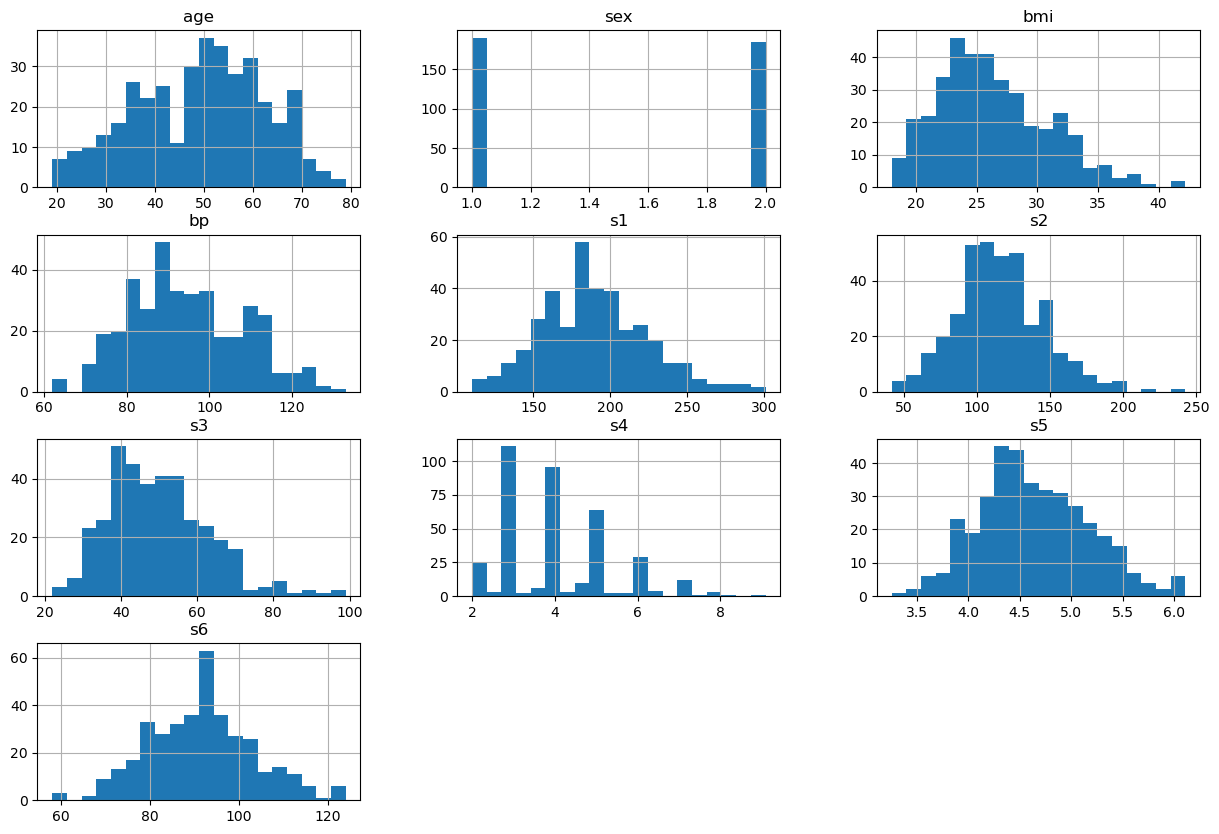

In [5]:
X_train.hist(bins=20, figsize=(15, 10))

- most of this data looks relatively normally distributed
- sex is currently treated as numeric but should obviously be categorical
- bmi looks a little skewed, could look into applying log function
- s4 looks categorical as well

array([[<Axes: title={'center': 'target'}>]], dtype=object)

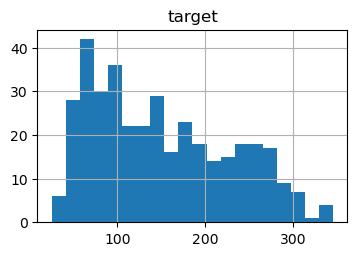

In [6]:
y_train.hist(bins=20,figsize=(4,2.5))

- nothing too special here

### General information

In [7]:
X_train.shape

(375, 10)

In [8]:
X_train.nunique()

age     58
sex      2
bmi    158
bp      91
s1     136
s2     270
s3      62
s4      59
s5     175
s6      56
dtype: int64

In [9]:
X_train.isna().sum() # no missing values??? unrealistic, but word

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [10]:
top_6 = X_train['s4'].value_counts().head(6)
print(f"The top 6 frequency numbers of s4 account for {top_6.sum()} or {((top_6.sum()/X_train.shape[0])*100).round(3)}% of the total data")
X_train['s4'].value_counts().head(10)
# not sure exactly how to handle this, or if i should do anything special
# maybe this isn't categorical

The top 6 frequency numbers of s4 account for 318 or 84.8% of the total data


s4
3.00    107
4.00     90
5.00     59
6.00     27
2.00     23
7.00     12
3.49      2
8.00      2
3.05      2
4.50      2
Name: count, dtype: int64

### Trying to create some new features

Text(0.5, 1.0, 'BMI logged')

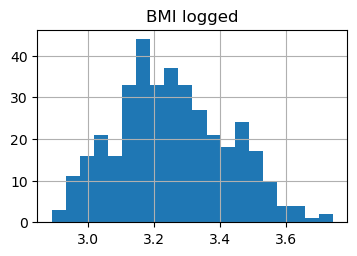

In [11]:
X_train['bmi_log'] = np.log(X_train['bmi'])
X_train['bmi_log'].hist(bins=20,figsize=(4,2.5)).set_title('BMI logged')

this looks better (more normal), but for now I will use the normal version of bmi, and then later I will come back to see if this feature yields a higher score

In [12]:
X_train = X_train.drop(columns=['bmi_log'])

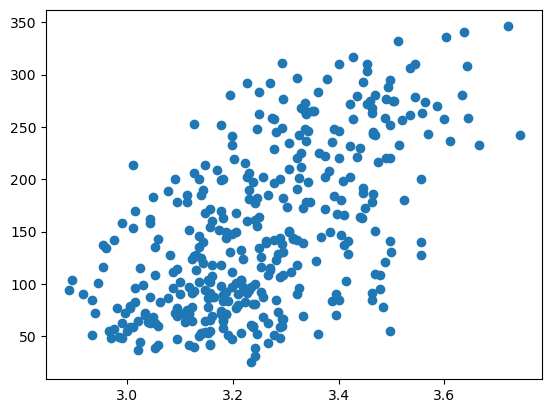

In [13]:
plt.scatter(np.log(X_train['bmi']),y_train)

# Models

## Ordinary Least Squares

### Preprocessing

In [14]:
numerical_variables = [col for col in X_train.columns]
numerical_variables.remove('sex')

categorical_variables = ['sex']

numerical_pipe = Pipeline(
    [
        # usually I would impute here but there aren't any missing values
        ('scaler',StandardScaler())
    ]
)

categorical_pipe = Pipeline(
    [
        ('encoder',OneHotEncoder())
    ]
)

preprocessing = ColumnTransformer(
    [
        ('numerical',numerical_pipe,numerical_variables),
        ('categorical',categorical_pipe,categorical_variables)
    ]
)

### Modeling

In [15]:
ols_reg = make_pipeline(preprocessing,LinearRegression())
print(f"R squared value of {(cross_validate(ols_reg,X_train,y_train,cv=5,scoring='r2')['test_score'].mean()).round(5)}")

R squared value of 0.52155


In [16]:
ols_reg.fit(X_train,y_train)
coefficients = ols_reg.named_steps['linearregression'].coef_
features = ols_reg.named_steps['columntransformer'].get_feature_names_out()
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients[0]})
coefficients_df

,Feature,Coefficient
0,numerical__age,-1.470428
1,numerical__bmi,26.435204
2,numerical__bp,14.482121
3,numerical__s1,-28.612766
4,numerical__s2,14.297011
5,numerical__s3,-0.532106
6,numerical__s4,6.469690
7,numerical__s5,35.188579
8,numerical__s6,3.331086
9,categorical__sex_1.0,12.235680


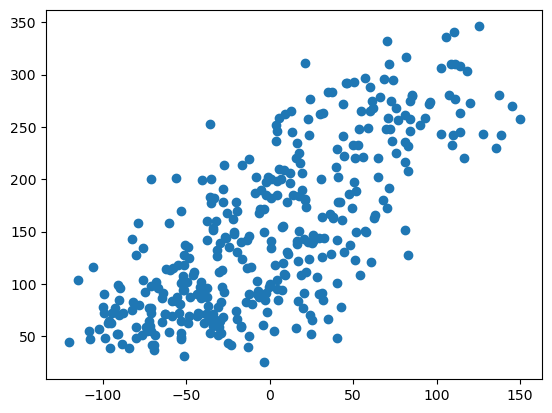

In [17]:
X_train_transformed = ols_reg.named_steps['columntransformer'].transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=features)
X_train_transformed_df['ols_reg'] = (
    X_train_transformed_df['numerical__age'] * -1.470428 +
    X_train_transformed_df['numerical__bmi'] * 26.435204 +
    X_train_transformed_df['numerical__bp'] * 14.482121 +
    X_train_transformed_df['numerical__s1'] * -28.612766 +
    X_train_transformed_df['numerical__s2'] * 14.297011 +
    X_train_transformed_df['numerical__s3'] * -0.532106 +
    X_train_transformed_df['numerical__s4'] * 6.469690 +
    X_train_transformed_df['numerical__s5'] * 35.188579 +
    X_train_transformed_df['numerical__s6'] * 3.331086 +
    X_train_transformed_df['categorical__sex_1.0'] * 12.235680 +
    X_train_transformed_df['categorical__sex_2.0'] * -12.235680
)
plt.scatter((X_train_transformed_df['ols_reg']),y_train)

### Trying with logging bmi

In [18]:
X_train_log_bmi = X_train.copy()
X_train_log_bmi['bmi_log'] = np.log(X_train_log_bmi['bmi'])
X_train_log_bmi = X_train_log_bmi.drop(columns=['bmi'])
X_train_log_bmi

,age,sex,bp,s1,s2,s3,s4,s5,s6,bmi_log
0,59.0,2.0,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,3.468856
1,72.0,2.0,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,3.417727
2,24.0,1.0,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,3.230804
3,50.0,1.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,3.135494
4,23.0,1.0,89.00,139.0,64.8,61.0,2.00,4.1897,68.0,3.117950
...,...,...,...,...,...,...,...,...,...,...
370,60.0,2.0,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,3.339322
371,47.0,2.0,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,3.214868
372,60.0,2.0,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,3.214868
373,36.0,1.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,3.401197


In [19]:
numerical_variables_log_bmi = [col for col in X_train_log_bmi.columns]
numerical_variables_log_bmi.remove('sex')
categorical_variables_log_bmi = ['sex']
numerical_pipe_log_bmi = Pipeline([('scaler',StandardScaler())])
categorical_pipe_log_bmi = Pipeline([('encoder',OneHotEncoder())])
preprocessing_log_bmi = ColumnTransformer([('numerical',numerical_pipe_log_bmi,numerical_variables_log_bmi),('categorical',categorical_pipe_log_bmi,categorical_variables_log_bmi)])
ols_reg_log_bmi = make_pipeline(preprocessing_log_bmi,LinearRegression())
print(f"R squared value of {(cross_validate(ols_reg_log_bmi,X_train_log_bmi,y_train,cv=5,scoring='r2')['test_score'].mean()).round(5)} after taking log of bmi")

R squared value of 0.51566 after taking log of bmi


### Trying with treating s4 as categorical

In [20]:
X_train_cat_s4 = X_train.copy()
X_train_cat_s4['s4_2'] = (X_train_cat_s4['s4'] == 2).astype(int)
X_train_cat_s4['s4_3'] = (X_train_cat_s4['s4'] == 3).astype(int)
X_train_cat_s4['s4_4'] = (X_train_cat_s4['s4'] == 4).astype(int)
X_train_cat_s4['s4_5'] = (X_train_cat_s4['s4'] == 5).astype(int)
X_train_cat_s4['s4_6'] = (X_train_cat_s4['s4'] == 6).astype(int)
X_train_cat_s4['s4_7'] = (X_train_cat_s4['s4'] == 7).astype(int)
X_train_cat_s4 = X_train_cat_s4.drop(columns = ['s4'])
X_train_cat_s4

,age,sex,bmi,bp,s1,s2,s3,s5,s6,s4_2,s4_3,s4_4,s4_5,s4_6,s4_7
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.8598,87.0,0,0,1,0,0,0
1,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.6728,85.0,0,0,1,0,0,0
2,24.0,1.0,25.3,84.00,198.0,131.4,40.0,4.8903,89.0,0,0,0,1,0,0
3,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.2905,80.0,0,0,1,0,0,0
4,23.0,1.0,22.6,89.00,139.0,64.8,61.0,4.1897,68.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.9836,93.0,0,0,1,0,0,0
371,47.0,2.0,24.9,75.00,225.0,166.0,42.0,4.4427,102.0,0,0,0,1,0,0
372,60.0,2.0,24.9,99.67,162.0,106.6,43.0,4.1271,95.0,0,0,0,0,0,0
373,36.0,1.0,30.0,95.00,201.0,125.2,42.0,5.1299,85.0,0,0,0,0,0,0


In [21]:
numerical_variables_cat_s4 = ['age','bmi','bp','s1','s2','s3','s5','s6']
categorical_variables_cat_s4 = ['sex','s4_2','s4_2','s4_3','s4_4','s4_5','s4_6','s4_7']
numerical_pipe_cat_s4 = Pipeline([('scaler',StandardScaler())])
categorical_pipe_cat_s4 = Pipeline([('encoder',OneHotEncoder())])
preprocessing_cat_s4 = ColumnTransformer([('numerical',numerical_pipe_cat_s4,numerical_variables_cat_s4),('categorical',categorical_pipe_cat_s4,categorical_variables_cat_s4)])
ols_reg_cat_s4 = make_pipeline(preprocessing_cat_s4,LinearRegression())
print(f"R squared value of {(cross_validate(ols_reg_cat_s4,X_train_cat_s4,y_train,cv=5,scoring='r2')['test_score'].mean()).round(5)} after making s4 categorical")

R squared value of 0.52113 after making s4 categorical


## Lasso

In [22]:
lasso_reg = make_pipeline(preprocessing,Lasso())

In [23]:
param_grid = [
    {'lasso__alpha': [a for a in np.logspace(-5,1,50)]}]
lasso_gridsearch = GridSearchCV(estimator = lasso_reg, 
                           param_grid = param_grid,
                           cv = 5, 
                           scoring='r2'
                           )
results = pd.DataFrame(lasso_gridsearch.fit(X_train,y_train).cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006266,8.167390e-04,0.001952,4.439255e-04,0.00001,{'lasso__alpha': 1e-05},0.476374,0.548942,0.516975,0.517531,0.547917,0.521548,0.026546,39
1,0.005402,4.918486e-04,0.001797,3.986616e-04,0.000013,{'lasso__alpha': 1.3257113655901082e-05},0.476374,0.548942,0.516975,0.517531,0.547917,0.521548,0.026546,38
2,0.005005,1.522672e-05,0.001909,5.006361e-04,0.000018,{'lasso__alpha': 1.757510624854793e-05},0.476374,0.548942,0.516975,0.517532,0.547917,0.521548,0.026546,37
3,0.005400,4.903495e-04,0.002001,5.001110e-07,0.000023,{'lasso__alpha': 2.3299518105153718e-05},0.476374,0.548942,0.516975,0.517532,0.547917,0.521548,0.026546,36
4,0.005467,4.507813e-04,0.001809,4.035889e-04,0.000031,{'lasso__alpha': 3.0888435964774785e-05},0.476373,0.548942,0.516975,0.517532,0.547917,0.521548,0.026546,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.003001,1.588662e-06,0.001599,4.908015e-04,3.237458,{'lasso__alpha': 3.2374575428176398},0.424220,0.520624,0.501855,0.543904,0.530481,0.504217,0.042283,46
46,0.002999,5.519789e-07,0.002001,3.989506e-07,4.291934,{'lasso__alpha': 4.291934260128778},0.417394,0.508303,0.492818,0.538792,0.518503,0.495162,0.041652,47
47,0.002797,3.983941e-04,0.001796,7.400268e-04,5.689866,{'lasso__alpha': 5.689866029018293},0.419557,0.502129,0.487749,0.541414,0.512680,0.492706,0.040585,48
48,0.003023,4.890141e-05,0.001958,1.716498e-04,7.54312,{'lasso__alpha': 7.543120063354607},0.420141,0.492668,0.480633,0.537728,0.504664,0.487167,0.038543,49


In [24]:
best_lasso_reg = lasso_gridsearch.best_estimator_
best_lasso_reg.fit(X_train,y_train)
coefficients = best_lasso_reg.named_steps['lasso'].coef_
features = best_lasso_reg.named_steps['columntransformer'].get_feature_names_out()
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients})
pd.options.display.float_format = '{:.4f}'.format
coefficients_df

,Feature,Coefficient
0,numerical__age,-0.8014
1,numerical__bmi,26.6771
2,numerical__bp,13.4741
3,numerical__s1,-8.8566
4,numerical__s2,-0.0000
5,numerical__s3,-9.7669
6,numerical__s4,1.9610
7,numerical__s5,28.0608
8,numerical__s6,2.9553
9,categorical__sex_1.0,21.5495


In [25]:
print(f"R squared value of {(cross_validate(best_lasso_reg,X_train,y_train,cv=5,scoring='r2')['test_score'].mean()).round(5)}")

R squared value of 0.52221


### Trying with Polynomial Features

In [26]:
numerical_variables_poly_feat = [col for col in X_train.columns]
numerical_variables_poly_feat.remove('sex')
categorical_variables_poly_feat = ['sex']
numerical_pipe_poly_feat = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('features',PolynomialFeatures(degree=2))
    ]
)
categorical_pipe_poly_feat = Pipeline(
    [
        ('encoder',OneHotEncoder())
    ]
)
preprocessing_poly_feat = ColumnTransformer(
    [
        ('numerical',numerical_pipe_poly_feat,numerical_variables_poly_feat),
        ('categorical',categorical_pipe_poly_feat,categorical_variables_poly_feat)
    ]
)

In [27]:
lasso_reg_poly_feat = make_pipeline(preprocessing_poly_feat,Lasso())
param_grid = [
    {'lasso__alpha': [a for a in np.linspace(.0001,10,50)]}]
lasso_gridsearch_poly_feat = GridSearchCV(estimator = lasso_reg_poly_feat, 
                           param_grid = param_grid,
                           cv = 5, 
                           scoring='r2'
                           )
results = pd.DataFrame(lasso_gridsearch_poly_feat.fit(X_train,y_train).cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0199,0.0011,0.0018,0.0007,0.0001,{'lasso__alpha': 0.0001},0.4210,0.5048,0.4237,0.3487,0.3052,0.4007,0.0687,50
1,0.0092,0.0035,0.0020,0.0000,0.2042,{'lasso__alpha': 0.20417959183673468},0.4270,0.5276,0.4362,0.4702,0.5291,0.4780,0.0435,48
2,0.0052,0.0007,0.0021,0.0002,0.4083,{'lasso__alpha': 0.40825918367346936},0.4178,0.5281,0.4403,0.5043,0.5364,0.4854,0.0477,41
3,0.0042,0.0004,0.0016,0.0004,0.6123,{'lasso__alpha': 0.6123387755102041},0.4264,0.5326,0.4533,0.5236,0.5357,0.4943,0.0455,33
4,0.0046,0.0005,0.0018,0.0004,0.8164,{'lasso__alpha': 0.8164183673469387},0.4252,0.5382,0.4641,0.5357,0.5389,0.5004,0.0472,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.0122,0.0010,0.0059,0.0008,9.1837,{'lasso__alpha': 9.18368163265306},0.4170,0.4924,0.4819,0.5376,0.4842,0.4826,0.0386,44
46,0.0101,0.0011,0.0052,0.0004,9.3878,{'lasso__alpha': 9.387761224489795},0.4162,0.4904,0.4805,0.5360,0.4830,0.4812,0.0383,45
47,0.0103,0.0008,0.0052,0.0004,9.5918,{'lasso__alpha': 9.59184081632653},0.4153,0.4884,0.4790,0.5344,0.4818,0.4798,0.0380,46
48,0.0090,0.0011,0.0054,0.0005,9.7959,{'lasso__alpha': 9.795920408163266},0.4145,0.4863,0.4775,0.5324,0.4806,0.4782,0.0376,47


In [28]:
pd.set_option("display.max_rows", 60)

best_lasso_reg_poly_feat = lasso_gridsearch_poly_feat.best_estimator_
best_lasso_reg_poly_feat.fit(X_train,y_train)
coefficients = best_lasso_reg_poly_feat.named_steps['lasso'].coef_
features = best_lasso_reg_poly_feat.named_steps['columntransformer'].get_feature_names_out()
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients})
pd.options.display.float_format = '{:.4f}'.format
coefficients_df[coefficients_df['Coefficient'] !=0 ].sort_values('Coefficient')

,Feature,Coefficient
6,numerical__s3,-10.2518
23,numerical__bmi s3,-1.5067
4,numerical__s1,-1.0490
14,numerical__age s2,-0.9113
40,numerical__s2^2,-0.3847
56,categorical__sex_2.0,-0.0000
17,numerical__age s5,0.2359
27,numerical__bp^2,0.2800
9,numerical__s6,0.6771
10,numerical__age^2,1.4158


In [29]:
print(f"R squared value of {(cross_validate(best_lasso_reg_poly_feat,X_train,y_train,cv=5,scoring='r2')['test_score'].mean()).round(5)}")

R squared value of 0.50999


# Predicting

The model with the highest r^2 was the initial Lasso model (though all the models performed around 0.52).

In [81]:
best_lasso_reg.fit(X_train,y_train)
holdout = pd.read_csv('Holdout/holdout_data.csv')
X_test = holdout.drop(columns=['patient','target'])
y_test = holdout[['patient','target']]

y_pred = best_lasso_reg.predict(X_test)

In [83]:
r2_score(y_test['target'],y_pred)

0.227270856785736

In [85]:
pd.reset_option('display.max_rows',None)
pd.DataFrame({'patient':y_test['patient'],'y_pred':y_pred,'y_test':y_test['target']})

,patient,y_pred,y_test
0,1,66.1844,75.0000
1,6,77.9001,138.0000
2,10,100.6307,101.0000
3,12,113.1217,179.0000
4,15,168.4504,171.0000
...,...,...,...
62,401,86.8096,93.0000
63,403,257.5072,275.0000
64,411,157.0944,136.0000
65,434,131.8269,49.0000


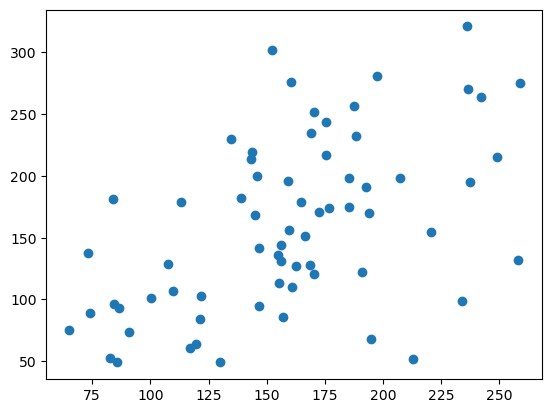

In [68]:
plt.scatter(y_pred,y_test)